In [1]:
import cv2
import numpy as np

## Setting up camera

In [ ]:
# def nothing(x):
#     pass

# cv2.namedWindow("Window")
# cv2.createTrackbar("Param Name", "Window", 0, 10, nothing)

In [2]:
def try_camera(func):
    cap = cv2.VideoCapture(0)

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        try:
            gray = func(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the resulting frame
            cv2.imshow('frame', gray)
        except:
            print("Nothing found...")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
# try_camera(lambda x : x)

## Part 1: Extracting Hand from Feed

In [ ]:
# ! {"pip install matplotlib"}

In [3]:
frame = np.load('open_palm.npy')

In [4]:
import matplotlib.pyplot as plt

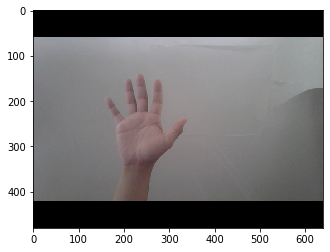

In [5]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [6]:
frame.shape

(480, 640, 3)

In [7]:
def get_skinmask(frame):
    lower_HSV = np.array([0, 70, 0], dtype = "uint8")  
    upper_HSV = np.array([25, 255, 255], dtype = "uint8")  

    convertedHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  
    skinMaskHSV = cv2.inRange(convertedHSV, lower_HSV, upper_HSV)  


    lower_YCrCb = np.array((0, 138, 67), dtype = "uint8")  
    upper_YCrCb = np.array((255, 173, 133), dtype = "uint8")  

    convertedYCrCb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)  
    skinMaskYCrCb = cv2.inRange(convertedYCrCb, lower_YCrCb, upper_YCrCb)  

    skinMask = cv2.add(skinMaskHSV,skinMaskYCrCb)  
    return skinMask

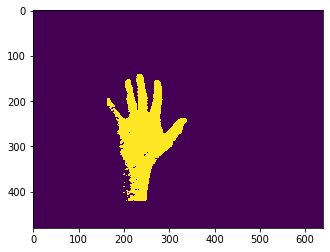

In [8]:
plt.imshow(get_skinmask(frame))

Testing Code

In [9]:
try_camera(get_skinmask)

KeyboardInterrupt: 

In [10]:
def morph_and_blur(frame, skinMask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))  
    skinMask = cv2.erode(skinMask, kernel, iterations = 1)  
    skinMask = cv2.dilate(skinMask, kernel, iterations = 1)  

    # blur the mask to help remove noise, then apply the  
    # mask to the frame  
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0) 
    skin = cv2.bitwise_and(frame, frame, mask = skinMask) 
    return skin

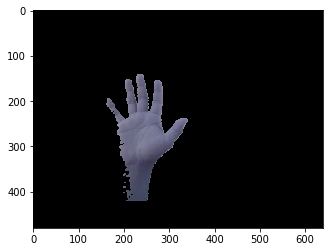

In [11]:
plt.imshow(morph_and_blur(frame, get_skinmask(frame)))

In [ ]:
isolate = lambda x : morph_and_blur(x, get_skinmask(x))
try_camera(isolate)

## Part 2: Connected Components for Gesture Recognition

In [13]:
ok_hand = np.load('ok.npy')

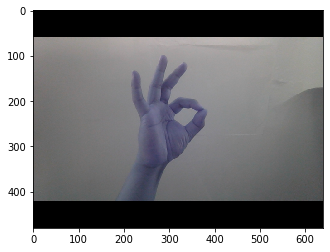

In [14]:
plt.imshow(ok_hand)

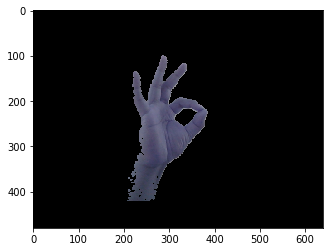

In [15]:
plt.imshow(isolate(ok_hand).astype(np.uint8))

In [16]:
def gray_thresh(frame):
    max_binary_value = 10
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)  
    ret, thresh = cv2.threshold(gray, 0, max_binary_value, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    return thresh # thresh if ret else None

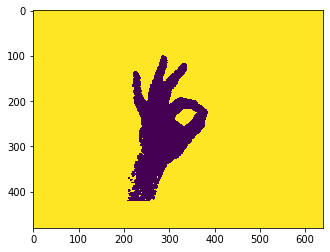

In [17]:
plt.imshow(gray_thresh(isolate(ok_hand)))

In [18]:
def arr2img(arr):
    arr = np.uint8(arr / np.max(arr) * 255)
    return cv2.merge([arr, arr, arr])

In [ ]:
# try_camera(lambda x : arr2img(gray_thresh(isolate(x))))

In [19]:
def get_connect(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    return arr2img(markers)

In [20]:
marks = get_connect(gray_thresh(isolate(ok_hand)))

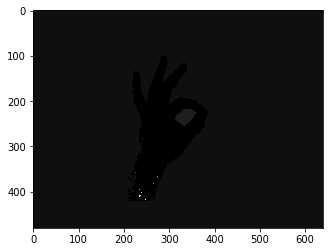

In [21]:
plt.imshow(marks)

Test out code so far...

In [22]:
render_comps = lambda x : get_connect(gray_thresh(isolate(x)))
# try_camera(render_comps)

In [23]:
def get_connect2(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    labeled_img = arr2img(markers)
    
    # sort by area of ROI
    statsSortedByArea = stats[np.argsort(stats[:, 4])]  
    roi = statsSortedByArea[-3][0:4]  
    x, y, w, h = roi  
    subImg = labeled_img[y:y+h, x:x+w]
    subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)
    
    _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    maxCntLength = 0  
    for i in range(0,len(contours)):  
        cntLength = len(contours[i])  
        if(cntLength>maxCntLength):  
            cnt = contours[i]  
            maxCntLength = cntLength  
    if(maxCntLength>=5):  
        ellipseParam = cv2.fitEllipse(cnt)
        (x,y), (MA, ma), angle = ellipseParam
        print(f"(x={x}, y={y}), (MA={MA}, ma={ma}), Angle={angle}")
        subImg = cv2.cvtColor(subImg, cv2.COLOR_GRAY2RGB);  
        subImg = cv2.ellipse(subImg,ellipseParam,(0,255,0),2)  

    subImg = cv2.resize(subImg, (0,0), fx=3, fy=3)
    return subImg

In [24]:
render_comps2 = lambda x : get_connect2(gray_thresh(isolate(x)))
try_camera(render_comps2)

(x=129.35714721679688, y=74.62240600585938), (MA=95.18578338623047, ma=146.02381896972656), Angle=0.0
(x=36.036277770996094, y=38.207637786865234), (MA=57.63686752319336, ma=76.73728942871094), Angle=149.97723388671875
(x=46.755584716796875, y=46.03141784667969), (MA=81.09147644042969, ma=101.7972183227539), Angle=162.35813903808594
(x=28.49056625366211, y=13.791974067687988), (MA=24.178346633911133, ma=69.50507354736328), Angle=76.75865936279297
(x=33.311790466308594, y=38.5390625), (MA=57.61451721191406, ma=79.72374725341797), Angle=126.04882049560547
(x=29.031301498413086, y=12.758938789367676), (MA=25.2249755859375, ma=66.63165283203125), Angle=75.77908325195312
(x=28.075664520263672, y=13.797443389892578), (MA=24.664485931396484, ma=63.79151916503906), Angle=77.65933990478516
(x=28.805070877075195, y=14.503063201904297), (MA=27.484539031982422, ma=62.980743408203125), Angle=76.31771087646484
(x=30.5143985748291, y=16.187166213989258), (MA=28.092697143554688, ma=62.8627815246582), 

(x=30.586017608642578, y=13.432064056396484), (MA=28.089115142822266, ma=62.94102478027344), Angle=82.10125732421875
(x=31.559707641601562, y=14.21645450592041), (MA=29.807893753051758, ma=63.52031326293945), Angle=82.65589904785156
(x=30.174224853515625, y=14.137633323669434), (MA=28.182458877563477, ma=62.2655143737793), Angle=82.08460998535156
(x=30.193771362304688, y=14.345529556274414), (MA=27.255613327026367, ma=61.08573913574219), Angle=81.23878479003906
(x=31.41588020324707, y=14.029351234436035), (MA=27.982267379760742, ma=63.792320251464844), Angle=83.9764175415039
(x=30.576562881469727, y=14.513591766357422), (MA=28.81812858581543, ma=61.407501220703125), Angle=82.98320007324219
(x=30.56443977355957, y=14.199051856994629), (MA=29.467117309570312, ma=60.748416900634766), Angle=80.61091613769531
(x=31.426651000976562, y=14.5387544631958), (MA=29.004653930664062, ma=62.14165115356445), Angle=81.72746276855469
(x=29.866466522216797, y=13.681303977966309), (MA=26.902183532714844,

(x=26.68071174621582, y=16.114803314208984), (MA=31.98211097717285, ma=58.119510650634766), Angle=96.1070327758789
(x=23.136306762695312, y=15.298544883728027), (MA=30.4303035736084, ma=57.73762130737305), Angle=118.27456665039062
(x=23.890058517456055, y=14.223241806030273), (MA=26.649763107299805, ma=50.46851348876953), Angle=90.9139404296875
(x=29.213726043701172, y=14.999652862548828), (MA=28.43097496032715, ma=61.818607330322266), Angle=81.63426208496094
(x=29.20193099975586, y=16.281843185424805), (MA=29.32819938659668, ma=63.94967269897461), Angle=75.74125671386719
(x=31.604734420776367, y=15.512800216674805), (MA=29.83599281311035, ma=63.45771408081055), Angle=78.39110565185547
(x=30.595809936523438, y=16.835330963134766), (MA=30.166067123413086, ma=62.217071533203125), Angle=78.67967224121094
(x=30.766942977905273, y=15.05382251739502), (MA=29.80429458618164, ma=62.91301727294922), Angle=78.45587158203125
(x=30.591171264648438, y=14.591315269470215), (MA=29.09998893737793, ma=

(x=30.28514862060547, y=14.456323623657227), (MA=27.83556365966797, ma=62.09441375732422), Angle=87.35316467285156
(x=30.479610443115234, y=14.018903732299805), (MA=27.157026290893555, ma=62.538787841796875), Angle=81.2559585571289
(x=29.939044952392578, y=14.0677490234375), (MA=27.662647247314453, ma=61.41131591796875), Angle=82.81079864501953
(x=28.627389907836914, y=13.126187324523926), (MA=27.16008758544922, ma=60.66096115112305), Angle=78.77066040039062
(x=30.35814666748047, y=16.16744613647461), (MA=27.879716873168945, ma=62.547489166259766), Angle=83.44953155517578
(x=28.589712142944336, y=13.48906135559082), (MA=25.688528060913086, ma=62.39478302001953), Angle=79.47761535644531
(x=29.271066665649414, y=14.174612045288086), (MA=25.884784698486328, ma=63.200748443603516), Angle=77.49320220947266
(x=38.9918327331543, y=64.45014190673828), (MA=59.05909729003906, ma=123.4170150756836), Angle=22.114139556884766
(x=30.01467514038086, y=13.866552352905273), (MA=27.760210037231445, ma=6

(x=13.204373359680176, y=28.308198928833008), (MA=21.199052810668945, ma=71.0478286743164), Angle=12.167083740234375
(x=12.834282875061035, y=31.063844680786133), (MA=22.21892547607422, ma=73.46809387207031), Angle=9.764296531677246
(x=12.720783233642578, y=31.71010971069336), (MA=22.661203384399414, ma=74.22343444824219), Angle=10.757445335388184
(x=28.236663818359375, y=13.671501159667969), (MA=24.019729614257812, ma=61.419952392578125), Angle=92.1770248413086
(x=29.326580047607422, y=14.029524803161621), (MA=25.77967643737793, ma=59.69844055175781), Angle=89.85710906982422
(x=29.65699005126953, y=13.355691909790039), (MA=26.840593338012695, ma=63.696659088134766), Angle=84.8479232788086
(x=30.544185638427734, y=14.135676383972168), (MA=26.696123123168945, ma=62.48634719848633), Angle=84.99363708496094
(x=34.901397705078125, y=27.299785614013672), (MA=37.13813781738281, ma=67.60175323486328), Angle=115.6949462890625
(x=30.362714767456055, y=13.394607543945312), (MA=25.827713012695312

(x=31.718524932861328, y=25.978065490722656), (MA=47.106536865234375, ma=58.206573486328125), Angle=77.2883071899414
(x=26.701366424560547, y=16.22134017944336), (MA=24.75016975402832, ma=58.27027893066406), Angle=74.3669204711914
(x=35.08924102783203, y=28.14698028564453), (MA=42.535465240478516, ma=58.35244369506836), Angle=50.084983825683594
(x=33.259246826171875, y=25.081785202026367), (MA=45.52045822143555, ma=56.908164978027344), Angle=80.72734832763672
(x=27.624292373657227, y=16.705575942993164), (MA=25.843505859375, ma=58.06474304199219), Angle=73.99070739746094
(x=29.324617385864258, y=14.93671989440918), (MA=25.205537796020508, ma=64.63736724853516), Angle=76.50243377685547
(x=12.259400367736816, y=31.76248550415039), (MA=25.134817123413086, ma=71.39033508300781), Angle=11.96076488494873
(x=27.512357711791992, y=12.486976623535156), (MA=23.32802391052246, ma=63.44586181640625), Angle=80.49520111083984
(x=30.686931610107422, y=14.488370895385742), (MA=24.610151290893555, ma=6

(x=30.414037704467773, y=17.076183319091797), (MA=34.11430740356445, ma=60.602394104003906), Angle=96.80036163330078
(x=12.903092384338379, y=25.156585693359375), (MA=19.685842514038086, ma=76.3465347290039), Angle=10.133880615234375
(x=31.582622528076172, y=12.626107215881348), (MA=24.893320083618164, ma=63.300575256347656), Angle=85.14002227783203
(x=30.350845336914062, y=12.773002624511719), (MA=24.883623123168945, ma=62.97635269165039), Angle=84.23541259765625
(x=37.90467071533203, y=27.25104522705078), (MA=63.708011627197266, ma=69.59809875488281), Angle=155.06732177734375
(x=28.829137802124023, y=12.948628425598145), (MA=25.30506134033203, ma=60.524818420410156), Angle=77.16068267822266
(x=28.13591766357422, y=12.726448059082031), (MA=25.313743591308594, ma=61.3561897277832), Angle=76.31346130371094
(x=29.075271606445312, y=12.922842979431152), (MA=25.55490493774414, ma=61.41689682006836), Angle=76.9681396484375
(x=29.682222366333008, y=16.614233016967773), (MA=33.00286102294922,

(x=33.89004135131836, y=34.365867614746094), (MA=52.94150924682617, ma=72.33384704589844), Angle=115.68717193603516
(x=30.089250564575195, y=15.868656158447266), (MA=27.23163414001465, ma=61.329776763916016), Angle=77.74262237548828
(x=29.71773338317871, y=13.396010398864746), (MA=27.3383846282959, ma=61.184818267822266), Angle=78.94287872314453
(x=32.10110855102539, y=25.866928100585938), (MA=47.22317886352539, ma=59.50613784790039), Angle=81.45523071289062
(x=30.498714447021484, y=18.11069107055664), (MA=29.99783706665039, ma=61.168701171875), Angle=75.08941650390625
(x=31.745285034179688, y=27.073352813720703), (MA=47.5814323425293, ma=59.180152893066406), Angle=90.21502685546875
(x=32.04248809814453, y=15.919651985168457), (MA=29.122386932373047, ma=63.44232940673828), Angle=79.38047790527344
(x=31.628021240234375, y=14.731372833251953), (MA=30.21811294555664, ma=63.593666076660156), Angle=80.47415161132812
(x=31.29064178466797, y=14.148215293884277), (MA=30.329195022583008, ma=62.

(x=30.423309326171875, y=15.099040031433105), (MA=34.57400131225586, ma=60.593788146972656), Angle=97.52813720703125
(x=30.32914924621582, y=15.016324996948242), (MA=34.18748474121094, ma=60.6710319519043), Angle=97.100341796875
(x=29.44284439086914, y=14.443390846252441), (MA=33.99421691894531, ma=58.566741943359375), Angle=94.14286804199219
(x=30.288576126098633, y=13.53134536743164), (MA=28.902820587158203, ma=62.877994537353516), Angle=78.26138305664062
(x=29.731290817260742, y=13.433664321899414), (MA=28.869524002075195, ma=62.56321334838867), Angle=76.72394561767578
(x=29.932886123657227, y=13.486916542053223), (MA=29.055503845214844, ma=61.21137237548828), Angle=77.7291488647461
(x=29.442211151123047, y=13.567209243774414), (MA=27.804473876953125, ma=62.30200958251953), Angle=78.19236755371094
(x=29.25009536743164, y=14.440566062927246), (MA=34.09590148925781, ma=58.46158981323242), Angle=93.6351318359375
(x=29.390735626220703, y=23.94142723083496), (MA=44.60271072387695, ma=53.

KeyboardInterrupt: 

## Part 3: Tracking 2D Finger Positions

In [25]:
def get_gray_thresh(x):
    img = arr2img(1 * (gray_thresh(isolate(x)) == 0))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

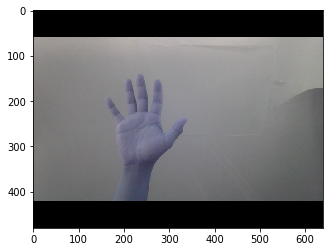

In [26]:
plt.imshow(np.load('open_palm.npy'))

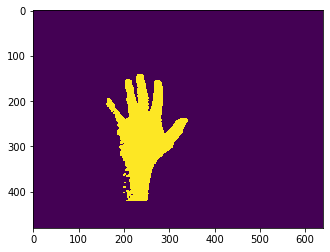

In [27]:
plt.imshow(get_gray_thresh(np.load('open_palm.npy')))

In [28]:
def get_hull(thresholdedHandImage):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    thresholdedHandImage = cv2.cvtColor(thresholdedHandImage, cv2.COLOR_GRAY2BGR)
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append(far)
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                
        print(fingerCount)
        
    return thresholdedHandImage

In [29]:
get_conv_img = lambda x : get_hull(get_gray_thresh(x))

3


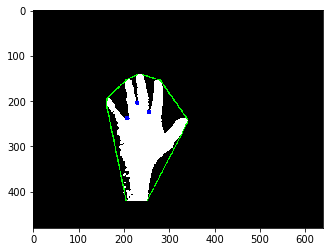

In [30]:
plt.imshow(get_conv_img(np.load('open_palm.npy')))

In [31]:
try_camera(get_conv_img)

1
2
2
2
1
2
2
1
2
2
1
1
3
2
2
3
3
4
4
4
4
5
4
4
1
1
1
0
0
0
0
0
1
0
4
3
3
4
3
3
3
2
3
2
2
3
2
2
3
1
0
0
1
0
0
0
3
3
4
3
3
3
3
4
3
3
4
3
1
1
2
2
1
4
2
3
4
5
4
3
3
7
6
6
4
4
6
5
4
3
5
4
5
6
4
4
4
4
5
4
5
3
1
1
1
0
0
0
1
0
1
1
1
0
1
1
0
0
3
0
0
2
0
0
0
0


KeyboardInterrupt: 

## Part 4: Control Mouse and Keyboard

Simple Gestures:
1. Finger Count:
    - 2 = open file
    - 3 = save file
2. OK Sign / Pinch:
    - Click

Complex Gestures:

3. Open - Close -> Close - Open
    - Next Song / Prev Song
4. Rotation of the Pinch 
5. Size of the Pinch
6. Move of Hand 
    - Move of the cursor

In [32]:
from scipy.stats import mode

In [113]:
def paint_conv_on_frame(thresholdedHandImage, regular_img, centers, open_closes, finger_counts):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText  = (10,30)
    bottomLeftCornerOfText2 = (10,60)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    thresholdedHandImage = regular_img
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    startEndPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append([far[i] for i in range(len(far))])
                    
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                    # cv2.circle(thresholdedHandImage,start,5,[i * 20,0,255],-1)
                    # cv2.circle(thresholdedHandImage,end,5,[i * 20 + 100,0,255],-1)
                    startEndPts.append([start[i] for i in range(len(start))])
                    # startEndPts.append([end[i] for i in range(len(end))])
                    
                    
        # Hand Tracking
        if len(startEndPts) > 5:
            M = cv2.moments(largestContour)  
            cX = 0 + 1 * int(M["m10"] / M["m00"])  
            cY = 0 + int(0.9 * M["m01"] / M["m00"])
            centers.append(np.array([cX, cY]))
            centers_mat = np.vstack(centers)
            center = np.mean(centers_mat, axis=0).astype(np.int)

            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = (10,30)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            cv2.circle(thresholdedHandImage, (center[0], center[1]), 5, [0,255,255], -1)
        
        # Draw Circle from Moment Center
        if len(startEndPts) > 5:
            pts = np.array(startEndPts)
            min_pts = np.array([cX, np.amin(pts, axis=0)[1]])
            dist = np.linalg.norm(min_pts - center, 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 60, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 120, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)
        
        # Open Palm Detection
        if len(fingerPts) > 0 and len(startEndPts) > 5:
            pts = np.array(fingerPts)
            mean_pts = np.mean(pts, axis=0)
            min_pts = np.amin(pts, axis=0)
            dist = np.linalg.norm(min_pts - center, 2)
            # thresholdedHandImage = cv2.circle(
            #     thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)

            # print(tuple(np.ceil(mean_pts).astype(int).tolist()))
            open_closes.append(1)
            finger_counts.append(len(fingerPts))
            mean_finger_count = int(np.mean(finger_counts))
            cv2.putText(thresholdedHandImage, f"Num Fingers: {mean_finger_count}", 
                        bottomLeftCornerOfText2, 
                        font, fontScale, fontColor, lineType)
        elif len(startEndPts) > 5:
            open_closes.append(0)
        else:
            open_closes.append(-1)
    else:
        open_closes.append(-1)
        
    if np.mean(open_closes) >= 0.33:
        cv2.putText(thresholdedHandImage, "Open", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    elif np.mean(open_closes) < 0.33 and np.mean(open_closes) >= -0.33:
        cv2.putText(thresholdedHandImage, "Closed", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    else:
        cv2.putText(thresholdedHandImage, "No Hand Detected", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
            
    return thresholdedHandImage, centers, open_closes

def draw_center_of_ellipse(img, pinches, angles):
    img = gray_thresh(isolate(img))
    try:
        ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
        markers = np.array(markers, dtype=np.uint8)  
        labeled_img = arr2img(markers)

        # sort by area of ROI
        statsSortedByArea = stats[np.argsort(stats[:, 4])]  
        roi = statsSortedByArea[-3][0:4]  
        x, y, w, h = roi  
        subImg = labeled_img[y:y+h, x:x+w]
        subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)

        _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
        maxCntLength = 0  
        for i in range(0,len(contours)):  
            cntLength = len(contours[i])  
            if(cntLength>maxCntLength):  
                cnt = contours[i]  
                maxCntLength = cntLength  
        if(maxCntLength>=5):  
            ellipseParam = cv2.fitEllipse(cnt)
            (x_sub, y_sub), (MA, ma), angle = ellipseParam
#             print(w * h, angle)
            angles.append(angle)
            pinches.append((w * h > 6000) * 1)
            return np.mean(pinches) > 0.7
        pinches.append(0)
        return False
    except:
        pinches.append(0)
        return False

#  -----------next song and prev song ------------------------
def open_to_close(centers_arr, open_closes_arr, dist_start, dist_end, timer):
    indexes = np.where(np.array(open_closes_arr) == -1)
    open_close_arr = np.delete(open_closes_arr, indexes)
    half_way = len(open_closes_arr)//2
    
    
    if (np.mean(open_closes_arr[:half_way]) > 0.8) and (np.mean(open_closes_arr[half_way:]) < 0.2):
        print("open -> close")
        timer = 45
        dist_start.append(centers_arr[-1])
        return dist_start, dist_end, timer
    if (np.mean(open_closes_arr[:half_way]) < 0.2) and (np.mean(open_closes_arr[half_way:]) > 0.8):
        print("close -> open")
        dist_end.append(centers_arr[-1])
        return dist_start, dist_end, timer
    return dist_start, dist_end, timer
# ------------------------------------------------------------

In [114]:
cap = cv2.VideoCapture(0)
centers_arr = []
open_closes_arr = [-1]
finger_counts = []
pinches = []
angles = []
#  -----------next song and prev song ------------------------
dist_start = []
dist_end = []
timer = 0
# ------------------------------------------------------------

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    # try:
    gray = get_gray_thresh(frame)
    disp, centers_arr, open_closes_arr = paint_conv_on_frame(
        gray, frame, centers_arr, open_closes_arr, finger_counts
    )
    
    #  -----------next song and prev song ------------------------
    dist_start, dist_end, timer = open_to_close(centers_arr, open_closes_arr, dist_start, dist_end, timer)
    timer -= 1
    if timer <= 0:
        dist_start, dist_end = [], []
        timer = 0
    if len(dist_start) >= 3 and len(dist_end) >=3:
        start_open_close = np.mean(dist_start, axis=0)
        end_open_close = np.mean(dist_end, axis=0)
        open_close = end_open_close[0]-start_open_close[0]
        print(open_close)
        if open_close > 0:
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText  = (10,125)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            cv2.putText(disp, "Next Song", 
                            bottomLeftCornerOfText, 
                            font, fontScale, fontColor, lineType)
        else:
            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText  = (10,125)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            cv2.putText(disp, "Prev Song", 
                            bottomLeftCornerOfText, 
                            font, fontScale, fontColor, lineType)
    # ------------------------------------------------------------
        
        
    
    ellipse_found = draw_center_of_ellipse(frame, pinches, angles)
    if ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText  = (10,90)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, "Pinch", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    if angles and angles[-1] - angles[0] > 60:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText3= (10,200)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, "CounterClockwise", 
                        bottomLeftCornerOfText3, 
                        font, fontScale, fontColor, lineType)
    if angles and angles[-1] - angles[0] < -60:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText4= (10,150)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, "Clockwise", 
                        bottomLeftCornerOfText4, 
                        font, fontScale, fontColor, lineType)
    
    if len(centers_arr) > 20:
        centers_arr = centers_arr[1:]
    if len(open_closes_arr) > 15:
        open_closes_arr = open_closes_arr[1:]
    if len(finger_counts) > 15:
        finger_counts = finger_counts[1:]
    if len(pinches) > 15:
        pinches = pinches[1:]
    if len(angles) > 15:
        angles = angles[1:]
        
    # Display the resulting frame
    cv2.imshow('frame', disp)
    # except:
    #     print("Nothing found...")
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

/Users/guest/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


close -> open
close -> open
close -> open
close -> open
close -> open
close -> open
open -> close
open -> close
open -> close
close -> open
close -> open
close -> open
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
-711.0
open -> close
open -> close
open -> close
close -> open
close -> open
close -> open
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
594.6666666666666
open -> close
423.16666666666663
open -> close
320.26666666666665
open -> close
251.66666666666663
open -> close
202.66666666666663
open -> close
165.91666666666663
165.91666666666663
165.91666666666663
165.91666666666663
165.91666666666663
165.91666666666663
165.91666666666663
165.91666666666663
165.

KeyboardInterrupt: 